<a href="https://colab.research.google.com/github/harshitadd/CrossPriv/blob/master/CrossPriv_Remote_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install syft==0.2.6 --quiet 
!pip install pydicom --quiet

In [2]:
##Importing Mini Batch Data 
import os 
import pydicom 
import cv2
import matplotlib.pyplot as plt
import csv  
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import syft as sy
import time
import copy
import numpy as np
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from syft.frameworks.torch.fl import utils
from syft.workers.websocket_client import WebsocketClientWorker

drive.mount('/content/drive')
sns.set(style="darkgrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
 def makeData(): 
  dcm_path=os.listdir('/content/drive/My Drive/Fed_Covid/minibatch/')
  dcm_data={}

  alpha = 1.5 # Contrast control (1.0-3.0)
  beta = 0 # Brightness control (0-100)

  ctr=0
  for file in dcm_path:
    name = '/content/drive/My Drive/Fed_Covid/minibatch/' + file
    temp = pydicom.dcmread(name)
    image = temp.pixel_array
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    adjusted = cv2.resize(image,(64,64))
    dcm_data[file]=adjusted
    ctr+=1

  labels=[]
  with open('/content/drive/My Drive/Fed_Covid/stage_2_train_labels.csv','r') as file:
    reader = csv.reader(file)
    for row in reader:
      labels.append(row)
  scaler = MinMaxScaler()
  pid=[]
  dicom=[]
  label=[]
  cid = 0
  for PID in labels:
    for key in dcm_data:
      if(key[:-4]==PID[0]):
        l=[]
        for val in dcm_data[key]:
          l.append(scaler.fit_transform(val))
        l = np.reshape(l,(3,64,64))
        dicom.append(l)
        label.append(int(PID[5]))
  return dicom, label  

      

In [4]:
dicom, label = makeData()

In [5]:
class Arguments():
    def __init__(self):
        self.batch_size = 4
        self.test_batch_size = 4
        self.epochs = 5
        self.lr = 0.01
        self.momentum = 0.5
        self.log_interval = 10

args = Arguments()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(dicom,label,test_size=0.3)

In [7]:
test_df = pd.DataFrame()
test_df['features']=x_test
test_df['labels']=y_test

In [8]:
x_train= np.array(x_train)
y_train= np.array(y_train)
x_test= np.array(x_test)
y_test= np.array(y_test)

In [78]:
class data_maker(Dataset):
  def __init__(self, images, labels):
        self.data = images 
        self.targets = labels 

        self.to_torchtensor()
        
  def __len__(self):
      return len(self.data)

  def to_torchtensor(self):      
      self.data=torch.from_numpy(self.data)
      self.labels=torch.from_numpy(self.targets)
  
  def __getitem__(self, idx):
      sample=self.data[idx]
      target=self.targets[idx]
      return sample,target

In [79]:
hook = sy.TorchHook(torch)
hospital = sy.VirtualWorker(hook, id="hospital")  
clinic = sy.VirtualWorker(hook, id="clinic")  

In [80]:
federated_train_data = data_maker(x_train,y_train).federate((hospital,clinic))

In [81]:
federated_train_loader = sy.FederatedDataLoader(federated_train_data,batch_size=args.batch_size)
test_data = data_maker(x_test,y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=args.test_batch_size)

In [82]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=8, stride = 2)  
        self.pool1 = nn.MaxPool2d(kernel_size=4,stride=2,padding=0)  
        self.conv2 = nn.Conv2d(32, 64, 8)
        self.pool2 = nn.MaxPool2d(4,2,padding=0)
        self.fc1 = nn.Linear(256, 64*64)
        self.fc2 = nn.Linear(64*64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x,dim=1)

In [83]:
local_losses=[]

In [86]:
def train(args, model,train_loader, optimizer, epoch):
    model.train()
    loss = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        model.send(data.location) 
        optimizer.zero_grad()
        output = model(data)
        out = loss(output, target)
        out.backward()
        optimizer.step()
        model.get() 
        if batch_idx % args.log_interval == 0:
            final_loss = out.get() 
            print('For Training Epoch: ' + str(epoch) + ' Loss is :' + str(final_loss) + 'at ' + str(data.location))
            local_losses.append(final_loss)
            

In [ ]:
model = Net().double()
optimizer = optim.SGD(model.parameters(), lr=args.lr) 
for epoch in range(1, 50):
  train(args, model, federated_train_loader, optimizer, epoch)

In [114]:
local_loss_hospital=[]
local_loss_clinic=[]

In [115]:
for i in range(0,len(local_losses)-8,8):
      local_loss_hospital.append(local_losses[i+3].detach().numpy()) #optimal loss of each local epoch iteration
for i in range(4,len(local_losses)-8,8):
  local_loss_clinic.append(local_losses[i+3].detach().numpy()) ##optimal loss of each local epoch iteration



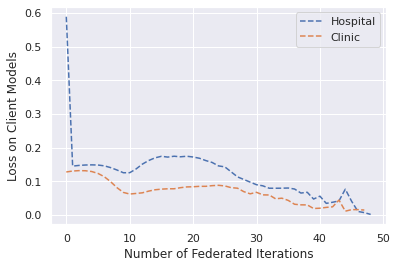

In [120]:
plt.xlabel('Number of Federated Iterations')
plt.ylabel('Loss on Client Models')
plt.plot(local_loss_hospital, label = 'Hospital', linestyle = 'dashed')
plt.plot(local_loss_clinic, label = 'Clinic', linestyle = 'dashed')
plt.legend()
plt.savefig('CrossPriv_Remote_Exec.pdf')

plt.show()
